In [12]:
from mesa import Agent

In [6]:
from mesa import Model

In [7]:
from mesa.time import RandomActivation

In [8]:
from mesa.space import MultiGrid

In [ ]:
from mesa.datacollection import DataCollector

In [ ]:
from collections import Counter

In [ ]:
import random

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.patches as patches

In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
import seaborn as sns

In [ ]:
# Agents can be in the states "Alive" or "Dead"
ALIVE = "Alive"
DEAD = "Dead"

# All agents inherit from the "CustomAgent" class
class CustomAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.state = ALIVE
        
    def is_alive(self):
        return self.state == ALIVE
    
    def die(self):
        self.state = DEAD
        
# "OX" agents represent areas with proper oxygen levels       
class OX(CustomAgent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
    def step(self):
        if self.state == DEAD:
            return
        
# "Al" agents represent areas with algae growth          
class AL(CustomAgent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.steps_since_last_reproduction = 0
        self.steps_since_last_OX_add = 0
        self.dying_for_steps = 0
        self.rotting_for_steps = 0

#Algae reproduce at a specified rate
    def try_add_new_AL(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        suitable_positions = [pos for pos in neighboring_positions if self.model.is_suitable_for_AL(pos)]
        if suitable_positions:
            new_position = self.random.choice(suitable_positions)
            self.model.add_agent(AL, position=new_position)
            self.model.record_AL_AL_interaction(self.pos)

# Additionally, algae produce oxygen at a specified rate
    def try_add_new_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True)
        suitable_positions = [pos for pos in neighboring_positions if self.model.is_suitable_for_OX(pos)]
        if suitable_positions:
            new_position = self.random.choice(suitable_positions)
            self.model.add_agent(OX, position=new_position)
            self.model.record_AL_OX_interaction(self.pos)

# After a specified length of time, algae begin to rot; the rotting process depletes oxygen from the 
# surrounding water
    def rotting(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True)
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            for agent in agents_in_cell:
                if isinstance(agent, OX) and agent.is_alive():
                    agent.die()
                    self.model.record_AB_OX_interaction(self.pos)
    
    def step(self):
        if not self.is_alive():
            return
        
        self.steps_since_last_reproduction += 1
        if self.steps_since_last_reproduction >= 1:
            self.try_add_new_AL()
            self.steps_since_last_reproduction = 0
            
        self.steps_since_last_OX_add += 1
        if self.steps_since_last_OX_add >= 4:
            self.try_add_new_OX()
            self.steps_since_last_OX_add = 0
            
        self.dying_for_steps += 1
        if self.dying_for_steps >= 13:
            self.rotting()
            self.model.record_AL_AB_interaction(self.pos)
            self.rotting_for_steps += 1
        
        if self.rotting_for_steps >= 4:
            self.dying_for_steps = 0
            self.die()

# "Invertebrate Herbivore Female" agent
class IHF(CustomAgent):
    def __init__(self, unique_id, model, reproduction_prob, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.reproduction_prob = reproduction_prob
        self.steps_since_last_reproduction = 0
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.steps_since_last_breath = 0
        self.has_consumed = False    

# IHF will attempt to reproduce with Invertebrate Herbivore Male agents at a specified interval
    def try_reproduce(self):
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])   
        if any((isinstance(agent, IHM) or 
            isinstance(agent, IHM2) or
            isinstance(agent, IHM3)) and agent.is_alive() for agent in agents_in_cell) and self.random.random() < self.reproduction_prob:
            
            num_offspring = random.randint(11, 15)
            
            for _ in range(num_offspring):
                reproduce_choice = self.random.random()
                if reproduce_choice <= 0.5:
                    next_id_IHF = self.model.reserve_next_IHF_id()
                    self.model.add_agent(IHF, next_id_IHF, reproduction_prob=self.reproduction_prob, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_ZOO_ZOO_interaction(self.pos)
                else:
                    next_id_IHM = self.model.reserve_next_IHM_id()
                    self.model.add_agent(IHM, next_id_IHM, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_ZOO_ZOO_interaction(self.pos)

# Check for oxygen in nearby cells
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions

# Move logic
    def move(self):
        OX_positions = self.check_OX()
        if OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_ZOO_OX_interaction(self.pos)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
                
# IHF grazes on algae
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if isinstance(agent, AL) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_ZOO_AL_interaction(self.pos)
                    agent.die()
                    self.has_consumed = True
                    self.steps_since_last_consumption = 0
                    break
        else:
            self.steps_since_last_consumption += 1

# IHF may spread disease among other invertebrate herbivores
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHF) or
                isinstance(agent, IHF2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM) or
                isinstance(agent, IHM2) or
                isinstance(agent, IHM3)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_ZOO_DIS_interaction(self.pos)
                    break
                
    def step(self):
        if not self.is_alive():
            return
        
        self.check_OX()
        
        self.move()

# Death logic
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 7:
            self.die()
            
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 5:
            self.die()
            
        self.steps_since_last_reproduction += 1
        if self.steps_since_last_reproduction >= 7:
            self.try_reproduce()
            self.steps_since_last_reproduction = 0

# "Invertebrate Herbivore male" agent
class IHM(CustomAgent):
    def __init__(self, unique_id, model, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.steps_since_last_breath = 0
        self.has_consumed = False
          
# Check for oxygen in nearby cells     
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions

# Move logic
    def move(self):
        OX_positions = self.check_OX()
        if OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_ZOO_OX_interaction(self.pos)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1

# IHM grazes on algae
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if isinstance(agent, AL) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_ZOO_AL_interaction(self.pos)
                    agent.die()
                    self.has_consumed = True
                    self.steps_since_last_consumption = 0
                    break
        else:
            self.steps_since_last_consumption += 1

# IHM may spread disease among other invertebrate herbivores
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHM) or
                isinstance(agent, IHM2) or
                isinstance(agent, IHM3) or
                isinstance(agent, IHF) or
                isinstance(agent, IHF2) or
                isinstance(agent, IHF3)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_ZOO_DIS_interaction(self.pos)
                    break
                
    def step(self):
        if not self.is_alive():
            return
        
        self.move()

# Death logic
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 7:
            self.die()
            
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 5:
            self.die()

# Second type of IHF
class IHF2(CustomAgent):
    def __init__(self, unique_id, model, reproduction_prob, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.reproduction_prob = reproduction_prob
        self.steps_since_last_reproduction = 0
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.steps_since_last_breath = 0
        self.has_consumed = False
        
    def try_reproduce(self):
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])   
        if any((isinstance(agent, IHM) or 
            isinstance(agent, IHM2) or
            isinstance(agent, IHM3)) and agent.is_alive() for agent in agents_in_cell) and self.random.random() < self.reproduction_prob:
            
            num_offspring = random.randint(9, 12)
            
            for _ in range(num_offspring):
                reproduce_choice = self.random.random()
                if reproduce_choice <= 0.5:
                    next_id_IHF2 = self.model.reserve_next_IHF2_id()
                    self.model.add_agent(IHF2, next_id_IHF2, reproduction_prob=self.reproduction_prob, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_ZOO_ZOO_interaction(self.pos)
                else:
                    next_id_IHM2 = self.model.reserve_next_IHM2_id()
                    self.model.add_agent(IHM2, next_id_IHM2, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_ZOO_ZOO_interaction(self.pos)
                    
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions

    def move(self):
        OX_positions = self.check_OX()
        if OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_ZOO_OX_interaction(self.pos)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if isinstance(agent, AL) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_ZOO_AL_interaction(self.pos)
                    agent.die()
                    self.has_consumed = True
                    self.steps_since_last_consumption = 0
                    break
        else:
            self.steps_since_last_consumption += 1
            
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHF) or
                isinstance(agent, IHF2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM) or
                isinstance(agent, IHM2) or
                isinstance(agent, IHM3)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_ZOO_DIS_interaction(self.pos)
                    break
                
    def step(self):
        if not self.is_alive():
            return
        
        self.check_OX()
        
        self.move()
        
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 9:
            self.die()
            
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 5:
            self.die()

        self.steps_since_last_reproduction += 1
        if self.steps_since_last_reproduction >= 7:
            self.try_reproduce()
            self.steps_since_last_reproduction = 0      

# Second type of IHM
class IHM2(CustomAgent):
    def __init__(self, unique_id, model, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.steps_since_last_breath = 0
        self.has_consumed = False
        
        
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions

    def move(self):
        OX_positions = self.check_OX()
        if OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_ZOO_OX_interaction(self.pos)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if isinstance(agent, AL) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_ZOO_AL_interaction(self.pos)
                    agent.die()
                    self.has_consumed = True
                    self.steps_since_last_consumption = 0
                    break
        else:
            self.steps_since_last_consumption += 1
            
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHM) or
                isinstance(agent, IHM2) or
                isinstance(agent, IHM3) or
                isinstance(agent, IHF) or
                isinstance(agent, IHF2) or
                isinstance(agent, IHF3)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_ZOO_DIS_interaction(self.pos)
                    break
                
    def step(self):
        if not self.is_alive():
            return
        
        self.check_OX()
        
        self.move()
        
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 9:
            self.die()
            
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 5:
            self.die()

# Third type of IHF
class IHF3(CustomAgent):
    def __init__(self, unique_id, model, reproduction_prob, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.reproduction_prob = reproduction_prob
        self.steps_since_last_reproduction = 0
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.steps_since_last_breath = 0
        self.has_consumed = False
        
        
    def try_reproduce(self):
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])   
        if any((isinstance(agent, IHM) or 
            isinstance(agent, IHM2) or
            isinstance(agent, IHM3)) and agent.is_alive() for agent in agents_in_cell) and self.random.random() < self.reproduction_prob:
            
            num_offspring = random.randint(7, 9)
            
            for _ in range(num_offspring):
                reproduce_choice = self.random.random()
                if reproduce_choice <= 0.5:
                    next_id_IHF3 = self.model.reserve_next_IHF3_id()
                    self.model.add_agent(IHF3, next_id_IHF3, reproduction_prob=self.reproduction_prob, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_ZOO_ZOO_interaction(self.pos)
                else:
                    next_id_IHM3 = self.model.reserve_next_IHM3_id()
                    self.model.add_agent(IHM3, next_id_IHM3, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_ZOO_ZOO_interaction(self.pos)
                    
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions

    def move(self):
        OX_positions = self.check_OX()
        if OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_ZOO_OX_interaction(self.pos)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if isinstance(agent, AL) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_ZOO_AL_interaction(self.pos)
                    agent.die()
                    self.has_consumed = True
                    self.steps_since_last_consumption = 0
                    break
        else:
            self.steps_since_last_consumption += 1
            
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHF) or
                isinstance(agent, IHF2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM) or
                isinstance(agent, IHM2) or
                isinstance(agent, IHM3)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_ZOO_DIS_interaction(self.pos)
                    break
                
    def step(self):
        if not self.is_alive():
            return
        
        self.check_OX()
        
        self.move()
        
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 11:
            self.die()
            
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 5:
            self.die()
            
        self.steps_since_last_reproduction += 1
        if self.steps_since_last_reproduction >= 7:
            self.try_reproduce()
            self.steps_since_last_reproduction = 0

# Third type of IHM
class IHM3(CustomAgent):
    def __init__(self, unique_id, model, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.steps_since_last_breath = 0
        self.has_consumed = False
        
        
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions

    def move(self):
        OX_positions = self.check_OX()
        if OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_ZOO_OX_interaction(self.pos)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if isinstance(agent, AL) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_ZOO_AL_interaction(self.pos)
                    agent.die()
                    self.has_consumed = True
                    self.steps_since_last_consumption = 0
                    break
        else:
            self.steps_since_last_consumption += 1
                    
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHM) or
                isinstance(agent, IHM2) or
                isinstance(agent, IHM3) or
                isinstance(agent, IHF) or
                isinstance(agent, IHF2) or
                isinstance(agent, IHF3)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_ZOO_DIS_interaction(self.pos)
                    break
                
    def step(self):
        if not self.is_alive():
            return
        
        self.check_OX()
        
        self.move()
        
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 11:
            self.die()
            
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 5:
            self.die()

# "Small Fish Female" agent
class SFF(CustomAgent):
    def __init__(self, unique_id, model, reproduction_prob, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.reproduction_prob = reproduction_prob
        self.steps_since_last_reproduction = 0
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.has_consumed = False
        self.steps_since_last_breath = 0 

# SFF will attempt to reproduce with SFMs at a specified interval
    def try_reproduce(self):
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])   
        if any((isinstance(agent, SFM) or 
            isinstance(agent, SFM2)) and agent.is_alive() for agent in agents_in_cell) and self.random.random() < self.reproduction_prob:
            
            self.steps_since_last_reproduction = 0
            num_offspring = random.randint(10, 15)
            for _ in range(num_offspring):
                reproduce_choice = self.random.random()
                if reproduce_choice <= 0.5:
                    next_id_SFF = self.model.reserve_next_SFF_id()
                    self.model.add_agent(SFF, next_id_SFF, reproduction_prob=self.reproduction_prob, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_SPF_SPF_interaction(self.pos)
                else:
                    next_id_SFM = self.model.reserve_next_SFM_id()
                    self.model.add_agent(SFM, next_id_SFM, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_SPF_SPF_interaction(self.pos)

# Check for oxygen in nearby cells
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions

# Small Predatory Fish look for prey in nearby cells
    def check_prey_SPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        prey_SPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3)) and agent.is_alive() for agent in agents_in_cell):
                    prey_SPF_positions.append(pos)
        return prey_SPF_positions

# Check for both oxygen and prey in cells
    def check_OX_and_prey_SPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_and_prey_SPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3) or
                isinstance(agent, OX)) and agent.is_alive() for agent in agents_in_cell):
                    OX_and_prey_SPF_positions.append(pos)
        return OX_and_prey_SPF_positions

# Move logic
    def move(self):
        OX_and_prey_SPF_positions = self.check_OX_and_prey_SPF()
        prey_SPF_positions = self.check_prey_SPF()
        OX_positions = self.check_OX()
        if OX_and_prey_SPF_positions:
            new_position = self.random.choice(OX_and_prey_SPF_positions)
            self.model.record_SPF_OX_interaction(self.pos)
        elif OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_SPF_OX_interaction(self.pos)
        elif prey_SPF_positions:
            new_position = self.random.choice(prey_SPF_positions)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, SFF) or
                isinstance(agent, SFF2) or
                isinstance(agent, SFM) or
                isinstance(agent, SFM2)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_SPF_DIS_interaction(self.pos)
                    break
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3)) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_SPF_ZOO_interaction(self.pos)
                    agent.die()
                    self.steps_since_last_consumption = 0
                    self.has_consumed = True
                else:
                    self.steps_since_last_consumption += 1
                    break
            
        self.steps_since_last_reproduction += 1
        if self.steps_since_last_reproduction >= 25:
            self.try_reproduce()
                
    def step(self):
        if not self.is_alive():
            return
        
        self.move()

# Death logic
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 14:
            self.die()
                
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 4:
            self.die()

# "Small Fish Male" agent; general logic is similar to that of SFF
class SFM(CustomAgent):
    def __init__(self, unique_id, model, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.has_consumed = False
        self.steps_since_last_breath = 0
        
        
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions
    
    def check_prey_SPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        prey_SPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3)) and agent.is_alive() for agent in agents_in_cell):
                    prey_SPF_positions.append(pos)
        return prey_SPF_positions
    
    def check_OX_and_prey_SPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_and_prey_SPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3) or
                isinstance(agent, OX)) and agent.is_alive() for agent in agents_in_cell):
                    OX_and_prey_SPF_positions.append(pos)
        return OX_and_prey_SPF_positions

    def move(self):
        OX_and_prey_SPF_positions = self.check_OX_and_prey_SPF()
        prey_SPF_positions = self.check_prey_SPF()
        OX_positions = self.check_OX()
        if OX_and_prey_SPF_positions:
            new_position = self.random.choice(OX_and_prey_SPF_positions)
            self.model.record_SPF_OX_interaction(self.pos)
        elif OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_SPF_OX_interaction(self.pos)
        elif prey_SPF_positions:
            new_position = self.random.choice(prey_SPF_positions)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, SFF) or
                isinstance(agent, SFF2) or
                isinstance(agent, SFM) or
                isinstance(agent, SFM2)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_SPF_DIS_interaction(self.pos)
                    break
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3)) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_SPF_ZOO_interaction(self.pos)
                    agent.die()
                    self.steps_since_last_consumption = 0
                    self.has_consumed = True
                else:
                    self.steps_since_last_consumption += 1
                    break            

    def step(self):
        if not self.is_alive():
            return
        
        self.move()

# Death logic
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 14:
            self.die()
                
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 4:
            self.die()

# Second type of SFF
class SFF2(CustomAgent):
    def __init__(self, unique_id, model, reproduction_prob, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.reproduction_prob = reproduction_prob
        self.steps_since_last_reproduction = 0
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.has_consumed = False
        self.steps_since_last_breath = 0
            
    def try_reproduce(self):
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])   
        if any((isinstance(agent, SFM) or 
            isinstance(agent, SFM2)) and agent.is_alive() for agent in agents_in_cell) and self.random.random() < self.reproduction_prob:
            
            self.steps_since_last_reproduction = 0
            num_offspring = random.randint(5, 10)
            for _ in range(num_offspring):
                reproduce_choice = self.random.random()
                if reproduce_choice <= 0.5:
                    next_id_SFF2 = self.model.reserve_next_SFF2_id()
                    self.model.add_agent(SFF2, next_id_SFF2, reproduction_prob=self.reproduction_prob, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_SPF_SPF_interaction(self.pos)
                else:
                    next_id_SFM2 = self.model.reserve_next_SFM2_id()
                    self.model.add_agent(SFM2, next_id_SFM2, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_SPF_SPF_interaction(self.pos)
    
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions
    
    def check_prey_SPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        prey_SPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3)) and agent.is_alive() for agent in agents_in_cell):
                    prey_SPF_positions.append(pos)
        return prey_SPF_positions
                    
    def check_OX_and_prey_SPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_and_prey_SPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3) or
                isinstance(agent, OX)) and agent.is_alive() for agent in agents_in_cell):
                    OX_and_prey_SPF_positions.append(pos)
        return OX_and_prey_SPF_positions

    def move(self):
        OX_and_prey_SPF_positions = self.check_OX_and_prey_SPF()
        prey_SPF_positions = self.check_prey_SPF()
        OX_positions = self.check_OX()
        if OX_and_prey_SPF_positions:
            new_position = self.random.choice(OX_and_prey_SPF_positions)
            self.model.record_SPF_OX_interaction(self.pos)
        elif OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_SPF_OX_interaction(self.pos)
        elif prey_SPF_positions:
            new_position = self.random.choice(prey_SPF_positions)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, SFF) or
                isinstance(agent, SFF2) or
                isinstance(agent, SFM) or
                isinstance(agent, SFM2)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_SPF_DIS_interaction(self.pos)
                    break
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3)) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_SPF_ZOO_interaction(self.pos)
                    agent.die()
                    self.steps_since_last_consumption = 0
                    self.has_consumed = True
                else:
                    self.steps_since_last_consumption += 1
                    break
            
        self.steps_since_last_reproduction += 1
        if self.steps_since_last_reproduction >= 25:
            self.try_reproduce()
            
    def step(self):
        if not self.is_alive():
            return
        self.move()
                
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 20:
            self.die()
                
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 4:
            self.die()

# Second type of SFM
class SFM2(CustomAgent):
    def __init__(self, unique_id, model, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.has_consumed = False
        self.steps_since_last_breath = 0
        
        
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions
    
    def check_prey_SPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        prey_SPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3)) and agent.is_alive() for agent in agents_in_cell):
                    prey_SPF_positions.append(pos)
        return prey_SPF_positions
    
    def check_OX_and_prey_SPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_and_prey_SPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3) or
                isinstance(agent, OX)) and agent.is_alive() for agent in agents_in_cell):
                    OX_and_prey_SPF_positions.append(pos)
        return OX_and_prey_SPF_positions

    def move(self):
        OX_and_prey_SPF_positions = self.check_OX_and_prey_SPF()
        prey_SPF_positions = self.check_prey_SPF()
        OX_positions = self.check_OX()
        if OX_and_prey_SPF_positions:
            new_position = self.random.choice(OX_and_prey_SPF_positions)
            self.model.record_SPF_OX_interaction(self.pos)
        elif OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_SPF_OX_interaction(self.pos)
        elif prey_SPF_positions:
            new_position = self.random.choice(prey_SPF_positions)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, SFF) or
                isinstance(agent, SFF2) or
                isinstance(agent, SFM) or
                isinstance(agent, SFM2)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_SPF_DIS_interaction(self.pos)
                    break
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, IHF) or 
                isinstance(agent, IHM) or 
                isinstance(agent, IHF2) or 
                isinstance(agent, IHM2) or
                isinstance(agent, IHF3) or
                isinstance(agent, IHM3)) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_SPF_ZOO_interaction(self.pos)
                    agent.die()
                    self.steps_since_last_consumption = 0
                    self.has_consumed = True
                else:
                    self.steps_since_last_consumption += 1
                    break
            
                
    def step(self):
        if not self.is_alive():
            return
        
        self.move()
        
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 20:
            self.die()
                
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 4:
            self.die()

# "Large Fish Female" agent
class LFF(CustomAgent):
    def __init__(self, unique_id, model, reproduction_prob, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.reproduction_prob = reproduction_prob
        self.steps_since_last_reproduction = 0
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.has_consumed = False
        self.steps_since_last_breath = 0

# LFF will try to reproduce with LFMs at a specified interval
    def try_reproduce(self):
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])   
        if any((isinstance(agent, LFM)) and agent.is_alive() for agent in agents_in_cell) and self.random.random() < self.reproduction_prob:
            
            self.steps_since_last_reproduction = 0
            num_offspring = random.randint(7, 9)
            
            for _ in range(num_offspring):
                reproduce_choice = self.random.random()
                if reproduce_choice <= 0.5:
                    next_id_LFF = self.model.reserve_next_LFF_id()
                    self.model.add_agent(LFF, next_id_LFF, reproduction_prob=self.reproduction_prob, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_LPF_LPF_interaction(self.pos)
                else:
                    next_id_LFM = self.model.reserve_next_LFM_id()
                    self.model.add_agent(LFM, next_id_LFM, consumption_prob=self.consumption_prob, disease_prob=self.disease_prob)
                    self.model.record_LPF_LPF_interaction(self.pos)

# Check for oxygen in nearby cells
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions

# Check for prey in nearby cells
    def check_prey_LPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        prey_LPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, SFF) or 
                isinstance(agent, SFM) or 
                isinstance(agent, SFF2) or 
                isinstance(agent, SFM2)) and agent.is_alive() for agent in agents_in_cell):
                    prey_LPF_positions.append(pos)
        return prey_LPF_positions

# Check for both oxygen and prey in nearby cells
    def check_OX_and_prey_LPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_and_prey_LPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, SFF) or 
                isinstance(agent, SFM) or 
                isinstance(agent, SFF2) or 
                isinstance(agent, SFM2) or
                isinstance(agent, OX)) and agent.is_alive() for agent in agents_in_cell):
                    OX_and_prey_LPF_positions.append(pos)
        return OX_and_prey_LPF_positions

# Move logic
    def move(self):
        OX_and_prey_LPF_positions = self.check_OX_and_prey_LPF()
        prey_LPF_positions = self.check_prey_LPF()
        OX_positions = self.check_OX()
        if OX_and_prey_LPF_positions:
            new_position = self.random.choice(OX_and_prey_LPF_positions)
            self.model.record_LPF_OX_interaction(self.pos)
        elif OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_LPF_OX_interaction(self.pos)
        elif prey_LPF_positions:
            new_position = self.random.choice(prey_LPF_positions)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, LFF) or
                isinstance(agent, LFM)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_LPF_DIS_interaction(self.pos)
                    break
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, SFF) or 
                isinstance(agent, SFM) or 
                isinstance(agent, SFF2) or 
                isinstance(agent, SFM2)) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_LPF_SPF_interaction(self.pos)
                    agent.die()
                    self.steps_since_last_consumption = 0
                    self.has_consumed = True
                else:
                    self.steps_since_last_consumption += 1
                    break
            
        self.steps_since_last_reproduction += 1
        if self.steps_since_last_reproduction >= 20:
            self.try_reproduce()
                
    def step(self):
        if not self.is_alive():
            return
        self.move()

# Death logic        
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 30:
            self.die()
                
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 5:
            self.die()   

# "Large Fish Male" agent; general logic similar to LFF
class LFM(CustomAgent):
    def __init__(self, unique_id, model, consumption_prob, disease_prob):
        super().__init__(unique_id, model)
        self.consumption_prob = consumption_prob
        self.disease_prob = disease_prob
        self.steps_since_last_consumption = 0
        self.has_consumed = False
        self.steps_since_last_breath = 0
        
        
    def check_OX(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any(isinstance(agent, OX) and agent.is_alive() for agent in agents_in_cell):
                OX_positions.append(pos)
        return OX_positions
    
    def check_prey_LPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        prey_LPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, SFF) or 
                isinstance(agent, SFM) or 
                isinstance(agent, SFF2) or 
                isinstance(agent, SFM2)) and agent.is_alive() for agent in agents_in_cell):
                    prey_LPF_positions.append(pos)
        return prey_LPF_positions
    
    def check_OX_and_prey_LPF(self):
        neighboring_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        OX_and_prey_LPF_positions = []
        for pos in neighboring_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            if any((isinstance(agent, SFF) or 
                isinstance(agent, SFM) or 
                isinstance(agent, SFF2) or 
                isinstance(agent, SFM2) or
                isinstance(agent, OX)) and agent.is_alive() for agent in agents_in_cell):
                    OX_and_prey_LPF_positions.append(pos)
        return OX_and_prey_LPF_positions

    def move(self):
        OX_and_prey_LPF_positions = self.check_OX_and_prey_LPF()
        prey_LPF_positions = self.check_prey_LPF()
        OX_positions = self.check_OX()
        if OX_and_prey_LPF_positions:
            new_position = self.random.choice(OX_and_prey_LPF_positions)
            self.model.record_LPF_OX_interaction(self.pos)
        elif OX_positions:
            new_position = self.random.choice(OX_positions)
            self.model.record_LPF_OX_interaction(self.pos)
        elif prey_LPF_positions:
            new_position = self.random.choice(prey_LPF_positions)
        else:
            possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
            new_position = self.random.choice(possible_moves)

        self.model.grid.move_agent(self, new_position)
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        breath = False
        for agent in agents_in_cell:
            if isinstance(agent, OX) and agent.is_alive():
                breath = True
                break
            if breath:
                self.steps_since_last_breath = 0
            else:
                self.steps_since_last_breath += 1
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, LFF) or
                isinstance(agent, LFM)) and agent.is_alive():
                if self.random.random() < self.disease_prob:
                    self.die()
                    self.model.record_LPF_DIS_interaction(self.pos)
                    break
        
        agents_in_cell = self.model.grid.get_cell_list_contents([new_position])
        for agent in agents_in_cell:
            if (isinstance(agent, SFF) or 
                isinstance(agent, SFM) or 
                isinstance(agent, SFF2) or 
                isinstance(agent, SFM2)) and agent.is_alive():
                if self.random.random() < self.consumption_prob:
                    self.model.record_LPF_SPF_interaction(self.pos)
                    agent.die()
                    self.steps_since_last_consumption = 0
                    self.has_consumed = True
                else:
                    self.steps_since_last_consumption += 1
                    break
                
    def step(self):
        if not self.is_alive():
            return
        self.move()

# Death logic
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_consumption >= 30:
            self.die()
                
        agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        if self.steps_since_last_breath >= 5:
            self.die()

# "Human Fishery" agent
class HF(CustomAgent):
    def __init__(self, unique_id, model, consumption_prob):
        super().__init__(unique_id, model)
        self.consumption_prob = consumption_prob
        self.steps_since_last_consumption = 0

    def consume(self):
        # Initially, no consumption has occurred
        consumed = False

        # Get all neighboring positions plus the current position
        all_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True)

        # Iterate through all positions and attempt to consume LFF and LFM agents
        for pos in all_positions:
            agents_in_cell = self.model.grid.get_cell_list_contents([pos])
            for agent in agents_in_cell:
                if isinstance(agent, (LFF, LFM)) and agent.is_alive():
                    if self.random.random() < self.consumption_prob:
                        agent.die()
                        self.model.record_HF_LPF_interaction(pos)
                        consumed = True
                        break

        return consumed

    def move_and_consume(self):
        possible_moves = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_moves)
        self.model.grid.move_agent(self, new_position)

        consumed = self.consume()

        if not consumed:
            self.steps_since_last_consumption += 1
        else:
            self.steps_since_last_consumption = 0

    def step(self):
        if not self.is_alive():
            return

        self.move_and_consume()

# Death logic
        if self.steps_since_last_consumption >= 100:
            self.die()

In [ ]:
# Model: initiates the model, positions agents, and collects the data
class ABModel(Model):
    def __init__(self, width, height, num_agents_OX, num_agents_AL, num_agents_IHF, 
                 num_agents_IHM, num_agents_IHF2, num_agents_IHM2, num_agents_IHF3,
                 num_agents_IHM3, num_agents_SFF, num_agents_SFM, num_agents_SFF2, 
                 num_agents_SFM2, num_agents_LFF, num_agents_LFM, num_agents_HF, 
                 reproduction_prob_IHF=1.0, consumption_prob_IHF=1.0, consumption_prob_IHM=1.0, 
                 reproduction_prob_IHF2=1.0, consumption_prob_IHF2=1.0, consumption_prob_IHM2=1.0, 
                 reproduction_prob_IHF3=1.0, consumption_prob_IHF3=1.0, consumption_prob_IHM3=1.0, 
                 reproduction_prob_SFF=1.0, consumption_prob_SFF=1.0, consumption_prob_SFM=1.0, 
                 reproduction_prob_SFF2=1.0, consumption_prob_SFF2=1.0, consumption_prob_SFM2=1.0, 
                 reproduction_prob_LFF=1.0, consumption_prob_LFF=1.0, consumption_prob_LFM=1.0,
                 disease_prob_IHF=1.0, disease_prob_IHM=1.0, disease_prob_IHF2=1.0,
                 disease_prob_IHM2=1.0, disease_prob_IHF3=1.0, disease_prob_IHM3=1.0,
                 disease_prob_SFF=1.0, disease_prob_SFM=1.0, disease_prob_SFF2=1.0,
                 disease_prob_SFM2=1.0, disease_prob_LFF=1.0, disease_prob_LFM=1.0, consumption_prob_HF=1.0):
        super().__init__()
        self.grid = MultiGrid(width, height, True)
        self.next_id = 0
        self.schedule = RandomActivation(self)
        self.agent_created_this_step = False
        self.initial_disease_prob_IHF = disease_prob_IHF
        self.initial_disease_prob_IHM = disease_prob_IHM
        self.initial_disease_prob_IHF2 = disease_prob_IHF2
        self.initial_disease_prob_IHM2 = disease_prob_IHM2
        self.initial_disease_prob_IHF3 = disease_prob_IHF3
        self.initial_disease_prob_IHM3 = disease_prob_IHM3
        self.initial_disease_prob_SFF = disease_prob_SFF
        self.initial_disease_prob_SFM = disease_prob_SFM
        self.initial_disease_prob_SFF2 = disease_prob_SFF2
        self.initial_disease_prob_SFM2 = disease_prob_SFM2
        self.initial_disease_prob_LFF = disease_prob_LFF
        self.initial_disease_prob_LFM = disease_prob_LFM
        self.positions = None
        self.HF_LPF_interactions = []
        self.LPF_SPF_interactions = []
        self.SPF_ZOO_interactions = []
        self.ZOO_AL_interactions = []
        self.AL_OX_interactions = []
        self.AB_OX_interactions = []
        self.LPF_OX_interactions = []
        self.SPF_OX_interactions = []
        self.ZOO_OX_interactions = []
        self.ZOO_ZOO_interactions = []
        self.SPF_SPF_interactions = []
        self.LPF_LPF_interactions = []
        self.AL_AL_interactions = []
        self.AL_AB_interactions = []
        self.ZOO_DIS_interactions = []
        self.SPF_DIS_interactions = []
        self.LPF_DIS_interactions = []
        
        self.agent_id_OX = 0
        self.agent_id_AL = 200000
        self.agent_id_IHF = 400000
        self.agent_id_IHM = 600000
        self.agent_id_IHF2 = 800000
        self.agent_id_IHM2 = 1000000
        self.agent_id_IHF3 = 1200000
        self.agent_id_IHM3 = 1400000
        self.agent_id_SFF = 1600000
        self.agent_id_SFM = 1800000
        self.agent_id_SFF2 = 2000000
        self.agent_id_SFM2 = 2200000
        self.agent_id_LFF = 2400000
        self.agent_id_LFM = 2500000
        self.agent_id_HF = 2600000

        for _ in range(num_agents_OX):
            self.add_agent(OX)
            
        for _ in range(num_agents_AL):
            self.add_agent(AL)
            
        for _ in range(num_agents_IHF):
            self.add_agent(IHF, reproduction_prob=reproduction_prob_IHF, consumption_prob=consumption_prob_IHF, disease_prob=disease_prob_IHF)
            
        for _ in range(num_agents_IHM):
            self.add_agent(IHM, consumption_prob=consumption_prob_IHM, disease_prob=disease_prob_IHM)
            
        for _ in range(num_agents_IHF2):
            self.add_agent(IHF2, reproduction_prob=reproduction_prob_IHF2, consumption_prob=consumption_prob_IHF2, disease_prob=disease_prob_IHF2)
            
        for _ in range(num_agents_IHM2):
            self.add_agent(IHM2, consumption_prob=consumption_prob_IHM2, disease_prob=disease_prob_IHM2)
            
        for _ in range(num_agents_IHF3):
            self.add_agent(IHF3, reproduction_prob=reproduction_prob_IHF3, consumption_prob=consumption_prob_IHF3, disease_prob=disease_prob_IHF3)
            
        for _ in range(num_agents_IHM3):
            self.add_agent(IHM3, consumption_prob=consumption_prob_IHM3, disease_prob=disease_prob_IHM3)
            
        for _ in range(num_agents_SFF):
            self.add_agent(SFF, reproduction_prob=reproduction_prob_SFF, consumption_prob=consumption_prob_SFF, disease_prob=disease_prob_SFF)
            
        for _ in range(num_agents_SFM):
            self.add_agent(SFM, consumption_prob=consumption_prob_SFM, disease_prob=disease_prob_SFM)
            
        for _ in range(num_agents_SFF2):
            self.add_agent(SFF2, reproduction_prob=reproduction_prob_SFF2, consumption_prob=consumption_prob_SFF2, disease_prob=disease_prob_SFF2)
            
        for _ in range(num_agents_SFM2):
            self.add_agent(SFM2, consumption_prob=consumption_prob_SFM2, disease_prob=disease_prob_SFM2)
            
        for _ in range(num_agents_LFF):
            self.add_agent(LFF, reproduction_prob=reproduction_prob_LFF, consumption_prob=consumption_prob_LFF,disease_prob=disease_prob_LFF)
            
        for _ in range(num_agents_LFM):
            self.add_agent(LFM, consumption_prob=consumption_prob_LFM, disease_prob=disease_prob_LFM)
            
        for _ in range(num_agents_HF):
            self.add_agent(HF, consumption_prob=consumption_prob_HF)          
            
        self.datacollector = DataCollector(
            model_reporters={
                "OX": lambda model: model.count_alive_agents(OX),
                "AL": lambda model: model.count_alive_agents(AL),
                "IHF1": lambda model: model.count_alive_agents(IHF),
                "IHM1": lambda model: model.count_alive_agents(IHM),
                "IHF2": lambda model: model.count_alive_agents(IHF2),
                "IHM2": lambda model: model.count_alive_agents(IHM2),                             
                "IHF3": lambda model: model.count_alive_agents(IHF3),
                "IHM3": lambda model: model.count_alive_agents(IHM3),                             
                "SFF1": lambda model: model.count_alive_agents(SFF),
                "SFM1": lambda model: model.count_alive_agents(SFM),
                "SFF2": lambda model: model.count_alive_agents(SFF2),
                "SFM2": lambda model: model.count_alive_agents(SFM2),                             
                "LFF": lambda model: model.count_alive_agents(LFF),
                "LFM": lambda model: model.count_alive_agents(LFM),
                "HF": lambda model: model.count_alive_agents(HF),
                "Positions": lambda model: model.positions,
                "HF-LPF": lambda model: Counter(model.HF_LPF_interactions),
                "LPF-SPF": lambda model: Counter(model.LPF_SPF_interactions),
                "SPF-ZOO": lambda model: Counter(model.SPF_ZOO_interactions),
                "ZOO-AL": lambda model: Counter(model.ZOO_AL_interactions),
                "AL-OX": lambda model: Counter(model.AL_OX_interactions),
                "AB-OX": lambda model: Counter(model.AB_OX_interactions),
                "LPF-OX": lambda model: Counter(model.LPF_OX_interactions),
                "SPF-OX": lambda model: Counter(model.SPF_OX_interactions),
                "ZOO-OX": lambda model: Counter(model.ZOO_OX_interactions),
                "ZOO-ZOO": lambda model: Counter(model.ZOO_ZOO_interactions),
                "SPF-SPF": lambda model: Counter(model.SPF_SPF_interactions),
                "LPF-LPF": lambda model: Counter(model.LPF_LPF_interactions),
                "AL-AL": lambda model: Counter(model.AL_AL_interactions),
                "AL-AB": lambda model: Counter(model.AL_AB_interactions),
                "ZOO-DIS": lambda model: Counter(model.ZOO_DIS_interactions), 
                "SPF-DIS": lambda model: Counter(model.SPF_DIS_interactions),
                "LPF-DIS": lambda model: Counter(model.LPF_DIS_interactions)
            }
        )
    
    def remove_dead_agents(self):
        for agent in self.schedule.agents[:]:
            if not agent.is_alive():
                self.grid.remove_agent(agent)
                self.schedule.remove(agent)
    
    def count_alive_agents(self, agent_type):
        return sum([1 for agent in self.schedule.agents if isinstance(agent, agent_type) and agent.state == "Alive"])
    
    def reset_interaction_counters(self):
        self.HF_LPF_interactions = Counter()
        self.LPF_SPF_interactions = Counter()
        self.SPF_ZOO_interactions = Counter()
        self.ZOO_AL_interactions = Counter()
        self.AL_OX_interactions = Counter()
        self.AB_OX_interactions = Counter()
        self.LPF_OX_interactions = Counter()
        self.SPF_OX_interactions = Counter()
        self.ZOO_OX_interactions = Counter()
        self.ZOO_ZOO_interactions = Counter()
        self.SPF_SPF_interactions = Counter ()
        self.LPF_LPF_interactions = Counter ()
        self.AL_AL_interactions = Counter ()
        self.AL_AB_interactions = Counter ()
        self.ZOO_DIS_interactions = Counter ()
        self.SPF_DIS_interactions = Counter ()
        self.LPF_DIS_interactions = Counter ()
        
    
    def collect_agent_positions(self):
        positions_OX = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, OX) and agent.is_alive()]
        positions_AL = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, AL) and agent.is_alive()]
        positions_IHF = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, IHF) and agent.is_alive()]
        positions_IHM = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, IHM) and agent.is_alive()]
        positions_IHF2 = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, IHF2) and agent.is_alive()]
        positions_IHM2 = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, IHM2) and agent.is_alive()]
        positions_IHF3 = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, IHF3) and agent.is_alive()]
        positions_IHM3 = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, IHM3) and agent.is_alive()]
        positions_SFF = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, SFF) and agent.is_alive()]
        positions_SFM = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, SFM) and agent.is_alive()]
        positions_SFF2 = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, SFF2) and agent.is_alive()]
        positions_SFM2 = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, SFM2) and agent.is_alive()]
        positions_LFF = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, LFF) and agent.is_alive()]
        positions_LFM = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, LFM) and agent.is_alive()]
        positions_HF = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if isinstance(agent, HF) and agent.is_alive()]
        self.positions = {
            "OX": positions_OX,
            "AL": positions_AL,
            "IHF": positions_IHF,
            "IHM": positions_IHM,
            "IHF2": positions_IHF2,
            "IHM2": positions_IHM2,
            "IHF3": positions_IHF3,
            "IHM3": positions_IHM3,
            "SFF": positions_SFF,
            "SFM": positions_SFM,
            "SFF2": positions_SFF2,
            "SFM2": positions_SFM2,
            "LFF": positions_LFF,
            "LFM": positions_LFM,
            "HF": positions_HF
        }
        
    def record_HF_LPF_interaction(self, pos):
        self.HF_LPF_interactions[pos] += 1

    def record_LPF_SPF_interaction(self, pos):
        self.LPF_SPF_interactions[pos] += 1
        
    def record_SPF_ZOO_interaction(self, pos):
        self.SPF_ZOO_interactions[pos] += 1
        
    def record_ZOO_AL_interaction(self, pos):
        self.ZOO_AL_interactions[pos] += 1
        
    def record_AL_OX_interaction(self, pos):
        self.AL_OX_interactions[pos] += 1
        
    def record_AB_OX_interaction(self, pos):
        self.AB_OX_interactions[pos] += 1
        
    def record_LPF_OX_interaction(self, pos):
        self.LPF_OX_interactions[pos] += 1
        
    def record_SPF_OX_interaction(self, pos):
        self.SPF_OX_interactions[pos] += 1
        
    def record_ZOO_OX_interaction(self, pos):
        self.ZOO_OX_interactions[pos] += 1
        
    def record_ZOO_ZOO_interaction(self, pos):
        self.ZOO_ZOO_interactions[pos] += 1
        
    def record_SPF_SPF_interaction(self, pos):
        self.SPF_SPF_interactions[pos] += 1
        
    def record_LPF_LPF_interaction(self, pos):
        self.LPF_LPF_interactions[pos] += 1
        
    def record_AL_AL_interaction(self, pos):
        self.AL_AL_interactions[pos] += 1
        
    def record_AL_AB_interaction(self, pos):
        self.AL_AB_interactions[pos] += 1
        
    def record_ZOO_DIS_interaction(self, pos):
        self.ZOO_DIS_interactions[pos] += 1
        
    def record_SPF_DIS_interaction(self, pos):
        self.SPF_DIS_interactions[pos] += 1
        
    def record_LPF_DIS_interaction(self, pos):
        self.LPF_DIS_interactions[pos] += 1        
        
    def is_suitable_for_OX(self, pos):
        cell_content = self.grid.get_cell_list_contents(pos)
        return not any(isinstance(agent, OX) and agent.state == "Alive" for agent in cell_content)
    
    def is_suitable_for_AL(self, pos):
        cell_content = self.grid.get_cell_list_contents(pos)
        return not any(isinstance(agent, AL) and agent.state == "Alive" for agent in cell_content)
    
    def reserve_next_AL_id(self):
        next_id = self.agent_id_AL
        self.agent_id_AL += 1
        return next_id
    
    def reserve_next_IHF_id(self):
        next_id = self.agent_id_IHF
        self.agent_id_IHF += 1
        return next_id
    
    def reserve_next_IHM_id(self):
        next_id = self.agent_id_IHM
        self.agent_id_IHM += 1
        return next_id

    def reserve_next_IHF2_id(self):
        next_id = self.agent_id_IHF2
        self.agent_id_IHF2 += 1
        return next_id
    
    def reserve_next_IHM2_id(self):
        next_id = self.agent_id_IHM2
        self.agent_id_IHM2 += 1
        return next_id
    
    def reserve_next_IHF3_id(self):
        next_id = self.agent_id_IHF3
        self.agent_id_IHF3 += 1
        return next_id
    
    def reserve_next_IHM3_id(self):
        next_id = self.agent_id_IHM3
        self.agent_id_IHM3 += 1
        return next_id
    
    def reserve_next_SFF_id(self):
        next_id = self.agent_id_SFF
        self.agent_id_SFF += 1
        return next_id
    
    def reserve_next_SFM_id(self):
        next_id = self.agent_id_SFM
        self.agent_id_SFM += 1
        return next_id
    
    def reserve_next_SFF2_id(self):
        next_id = self.agent_id_SFF2
        self.agent_id_SFF2 += 1
        return next_id
    
    def reserve_next_SFM2_id(self):
        next_id = self.agent_id_SFM2
        self.agent_id_SFM2 += 1
        return next_id
    
    def reserve_next_LFF_id(self):
        next_id = self.agent_id_LFF
        self.agent_id_LFF += 1
        return next_id
    
    def reserve_next_LFM_id(self):
        next_id = self.agent_id_LFM
        self.agent_id_LFM += 1
        return next_id
    
    def reserve_next_HF_id(self):
        next_id = self.agent_id_HF
        self.agent_id_HF += 1
        return next_id
    
    def add_agent(self, agent_type, agent_id=None, position=None, reproduction_prob=1.0, consumption_prob=0.5, disease_prob=1.0):         
        if agent_type == OX:
            suitable_positions = [(x, y) for x in range(self.grid.width) for y in range(self.grid.height) if self.is_suitable_for_OX((x, y))]
            if suitable_positions:
                position = self.random.choice(suitable_positions)
                agent_id = self.agent_id_OX
                self.agent_id_OX += 1
                agent = agent_type(agent_id, self)
                
        if agent_type == AL:
            suitable_positions = [(x, y) for x in range(self.grid.width) for y in range(self.grid.height) if self.is_suitable_for_AL((x, y))]
            if suitable_positions:
                position = self.random.choice(suitable_positions)
                agent_id = self.agent_id_AL
                self.agent_id_AL += 1
                agent = agent_type(agent_id, self)  
            
        elif agent_type == IHF:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_IHF
                self.agent_id_IHF += 1
            agent = agent_type(agent_id, self, reproduction_prob, consumption_prob, disease_prob)
            
        elif agent_type == IHM:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_IHM
                self.agent_id_IHM += 1
            agent = agent_type(agent_id, self, consumption_prob, disease_prob)

        elif agent_type == IHF2:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_IHF2
                self.agent_id_IHF2 += 1
            agent = agent_type(agent_id, self, reproduction_prob, consumption_prob, disease_prob)
            
        elif agent_type == IHM2:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_IHM2
                self.agent_id_IHM2 += 1
            agent = agent_type(agent_id, self, consumption_prob, disease_prob)
            
        elif agent_type == IHF3:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_IHF3
                self.agent_id_IHF3 += 1
            agent = agent_type(agent_id, self, reproduction_prob, consumption_prob, disease_prob)
            
        elif agent_type == IHM3:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_IHM3
                self.agent_id_IHM3 += 1
            agent = agent_type(agent_id, self, consumption_prob, disease_prob)
            
        elif agent_type == SFF:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_SFF
                self.agent_id_SFF += 1
            agent = agent_type(agent_id, self, reproduction_prob, consumption_prob, disease_prob)
            
        elif agent_type == SFM:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_SFM
                self.agent_id_SFM += 1
            agent = agent_type(agent_id, self, consumption_prob, disease_prob)
            
        elif agent_type == SFF2:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_SFF2
                self.agent_id_SFF2 += 1
            agent = agent_type(agent_id, self, reproduction_prob, consumption_prob, disease_prob)
            
        elif agent_type == SFM2:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_SFM2
                self.agent_id_SFM2 += 1
            agent = agent_type(agent_id, self, consumption_prob, disease_prob)
            
        elif agent_type == LFF:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_LFF
                self.agent_id_LFF += 1
            agent = agent_type(agent_id, self, reproduction_prob, consumption_prob, disease_prob)
            
        elif agent_type == LFM:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_LFM
                self.agent_id_LFM += 1
            agent = agent_type(agent_id, self, consumption_prob, disease_prob)
            
        elif agent_type == HF:
            position = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            if agent_id is None:
                agent_id = self.agent_id_HF
                self.agent_id_HF += 1
            agent = agent_type(agent_id, self, consumption_prob)
            
        self.grid.place_agent(agent, position)
        self.schedule.add(agent)
        
    def update_IHF_disease_prob(self):
        total_IHF = self.count_alive_agents(IHF)
        new_disease_prob = 0.035 if total_IHF >= 50 else self.initial_disease_prob_IHF
        for agent in self.schedule.agents:
            if isinstance(agent, IHF):
                agent.disease_prob = new_disease_prob
                
    def update_IHM_disease_prob(self):
        total_IHM = self.count_alive_agents(IHM)
        new_disease_prob = 0.035 if total_IHM >= 50 else self.initial_disease_prob_IHM
        for agent in self.schedule.agents:
            if isinstance(agent, IHM):
                agent.disease_prob = new_disease_prob
                
    def update_IHF2_disease_prob(self):
        total_IHF2 = self.count_alive_agents(IHF2)
        new_disease_prob = 0.035 if total_IHF2 >= 50 else self.initial_disease_prob_IHF2
        for agent in self.schedule.agents:
            if isinstance(agent, IHF2):
                agent.disease_prob = new_disease_prob
                
    def update_IHM2_disease_prob(self):
        total_IHM2 = self.count_alive_agents(IHM2)
        new_disease_prob = 0.035 if total_IHM2 >= 50 else self.initial_disease_prob_IHM2
        for agent in self.schedule.agents:
            if isinstance(agent, IHM2):
                agent.disease_prob = new_disease_prob
                
    def update_IHF3_disease_prob(self):
        total_IHF3 = self.count_alive_agents(IHF3)
        new_disease_prob = 0.035 if total_IHF3 >= 50 else self.initial_disease_prob_IHF3
        for agent in self.schedule.agents:
            if isinstance(agent, IHF3):
                agent.disease_prob = new_disease_prob
                
    def update_IHM3_disease_prob(self):
        total_IHM3 = self.count_alive_agents(IHM3)
        new_disease_prob = 0.035 if total_IHM3 >= 50 else self.initial_disease_prob_IHM3
        for agent in self.schedule.agents:
            if isinstance(agent, IHM3):
                agent.disease_prob = new_disease_prob
                
    def update_SFF_disease_prob(self):
        total_SFF = self.count_alive_agents(SFF)
        new_disease_prob = 0.035 if total_SFF >= 20 else self.initial_disease_prob_SFF
        for agent in self.schedule.agents:
            if isinstance(agent, SFF):
                agent.disease_prob = new_disease_prob
                
    def update_SFM_disease_prob(self):
        total_SFM = self.count_alive_agents(SFM)
        new_disease_prob = 0.035 if total_SFM >= 20 else self.initial_disease_prob_SFM
        for agent in self.schedule.agents:
            if isinstance(agent, SFM):
                agent.disease_prob = new_disease_prob
                
    def update_SFF2_disease_prob(self):
        total_SFF2 = self.count_alive_agents(SFF2)
        new_disease_prob = 0.035 if total_SFF2 >= 20 else self.initial_disease_prob_SFF2
        for agent in self.schedule.agents:
            if isinstance(agent, SFF2):
                agent.disease_prob = new_disease_prob
                
    def update_SFM2_disease_prob(self):
        total_SFM2 = self.count_alive_agents(SFM2)
        new_disease_prob = 0.035 if total_SFM2 >= 20 else self.initial_disease_prob_SFM2
        for agent in self.schedule.agents:
            if isinstance(agent, SFM2):
                agent.disease_prob = new_disease_prob
                
    def update_LFF_disease_prob(self):
        total_LFF = self.count_alive_agents(LFF)
        new_disease_prob = 0.035 if total_LFF >= 12 else self.initial_disease_prob_LFF
        for agent in self.schedule.agents:
            if isinstance(agent, LFF):
                agent.disease_prob = new_disease_prob
                
    def update_LFM_disease_prob(self):
        total_LFM = self.count_alive_agents(LFM)
        new_disease_prob = 0.035 if total_LFM >= 12 else self.initial_disease_prob_LFM
        for agent in self.schedule.agents:
            if isinstance(agent, LFM):
                agent.disease_prob = new_disease_prob
        
    def step(self):
        self.reset_interaction_counters()
        self.update_IHF_disease_prob()
        self.update_IHM_disease_prob()
        self.update_IHF2_disease_prob()
        self.update_IHM2_disease_prob()
        self.update_IHF3_disease_prob()
        self.update_IHM3_disease_prob()
        self.update_SFF_disease_prob()
        self.update_SFM_disease_prob()
        self.update_SFF2_disease_prob()
        self.update_SFM2_disease_prob()
        self.update_LFF_disease_prob()
        self.update_LFM_disease_prob()
        self.collect_agent_positions()
        self.schedule.step()
        self.remove_dead_agents()
        self.datacollector.collect(self)

In [ ]:
# code for running the model
all_runs_data = []
num_runs = 10
max_steps = 400

for _ in range(num_runs):
    
    model = ABModel(20, 20, 300, 350, 45, 45, 40, 40, 35, 35, 19, 19, 15, 15, 11, 11, 2,
                
                    reproduction_prob_IHF=0.381,consumption_prob_IHF=0.935,consumption_prob_IHM=0.935,
                
                    reproduction_prob_IHF2=0.381,consumption_prob_IHF2=0.925,consumption_prob_IHM2=0.925,
                
                    reproduction_prob_IHF3=0.381,consumption_prob_IHF3=0.915,consumption_prob_IHM3=0.915,
                
                    reproduction_prob_SFF=0.439,consumption_prob_SFF=0.182,consumption_prob_SFM=0.182,
                
                    reproduction_prob_SFF2=0.439,consumption_prob_SFF2=0.179,consumption_prob_SFM2=0.179,
                
                    reproduction_prob_LFF=0.429,consumption_prob_LFF=0.1875,consumption_prob_LFM=0.1875,
                
                    disease_prob_IHF=0.0057,disease_prob_IHM=0.0059,
                
                    disease_prob_IHF2=0.0051,disease_prob_IHM2=0.0053,
                
                    disease_prob_IHF3=0.0047,disease_prob_IHM3=0.0049,
               
                    disease_prob_SFF=0.0017,disease_prob_SFM=0.0019,
               
                    disease_prob_SFF2=0.0017,disease_prob_SFM2=0.0019,
                
                    disease_prob_LFF=0.001,disease_prob_LFM=0.001,consumption_prob_HF=0.2)
    
    for _ in range(max_steps):
        model.step()
        
    run_data = model.datacollector.get_model_vars_dataframe()
    all_runs_data.append(run_data)

In [ ]:
aggregated_data = {}

data_types = ["OX", "AL", "IHF1", "IHM1", "IHF2", "IHM2", "IHF3", 
              "IHM3", "SFF1", "SFM1", "SFF2", "SFM2", "LFF", "LFM", "HF",
              "HF-LPF", "LPF-SPF", "SPF-ZOO", "ZOO-AL", "AL-OX", "AB-OX",
              "LPF-OX", "SPF-OX", "ZOO-OX", "LPF-LPF", "SPF-SPF",
              "ZOO-ZOO", "AL-AL", "AL-AB", "ZOO-DIS", "SPF-DIS", "LPF-DIS"]

for data_type in data_types:
    if "Counter" in str(type(all_runs_data[0][data_type][0])):
        aggregated_data[data_type] = [Counter() for _ in range(max_steps)]
    else:
        aggregated_data[data_type] = [0] * max_steps
    
for run_data in all_runs_data:
    for data_type in data_types:
        for step in range(max_steps):
            if isinstance(aggregated_data[data_type][step], Counter):
                aggregated_data[data_type][step].update(run_data[data_type][step])
            else:
                aggregated_data[data_type][step] += run_data[data_type][step]

In [ ]:
average_data = {}

for data_type, values in aggregated_data.items():
    if isinstance(values[0], Counter):
        average_counters = []
        for counter in values:
            average_counter = Counter()
            for key, count in counter.items():
                average_count = count / num_runs
                average_counter[key] = average_count
            average_counters.append(average_counter)
        average_data[data_type] = average_counters
    else:
        average_data[data_type] = [value / num_runs for value in values]

In [ ]:
non_interaction_types = [
     "OX", "AL", "IHF1", "IHM1", "IHF2", "IHM2", "IHF3", "IHM3", 
    "SFF1", "SFM1", "SFF2", "SFM2", "LFF", "LFM", "HF"
]

non_interaction_data = {data_type: average_data[data_type] for data_type in non_interaction_types}
non_interaction_df = pd.DataFrame(non_interaction_data)
print("Non-Interaction Data:")
print(non_interaction_df.to_string())

Non-Interaction Data:
,        OX     AL   IHF1   IHM1  IHF2  IHM2  IHF3  IHM3  SFF1  SFM1  SFF2  SFM2   LFF   LFM   HF
,0    300.0  343.5   43.2   43.6  38.4  38.2  33.1  34.4  18.5  17.9  14.3  14.7  10.9  10.9  2.0
,1    300.0  342.5   41.7   42.0  37.3  36.7  31.8  33.0  18.1  17.8  14.1  14.7  10.7  10.9  2.0
,2    300.0  346.7   40.2   40.2  36.0  34.9  30.5  32.1  17.7  17.4  14.1  14.6  10.5  10.8  2.0
,3    383.2  349.2   39.5   38.6  35.1  33.8  29.3  31.2  17.1  16.6  14.0  14.0  10.5  10.8  2.0
,4    390.1  348.1   38.3   37.3  33.9  32.4  28.5  30.0  16.6  16.5  13.7  13.7  10.5  10.8  2.0
,5    393.3  353.0   37.2   36.4  32.8  31.9  27.8  29.1  16.4  16.1  13.7  13.5  10.3  10.8  2.0
,6    395.3  355.4   52.0   51.7  44.8  45.6  34.5  34.3  16.2  15.7  13.6  13.3  10.0  10.7  2.0
,7    399.0  323.9   49.3   48.7  43.4  43.1  33.5  33.5  16.1  15.4  13.6  13.2   9.7  10.5  2.0
,8    399.7  318.8   46.2   46.2  41.4  41.4  32.4  32.4  15.9  15.2  13.5  12.8   9.6  10.4  2.

In [ ]:
interaction_types = [
    "LPF-SPF", "SPF-ZOO", "ZOO-AL", "AL-OX", "AB-OX", 
    "LPF-OX", "SPF-OX", "ZOO-OX", "LPF-LPF", "SPF-SPF", "ZOO-ZOO",
    "AL-AL", "AL-AB", "ZOO-DIS", "SPF-DIS", "LPF-DIS"
]

In [ ]:
interactions_data = average_data["LPF-SPF"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nLPF-SPF Averaged Data: ")
print(interactions_str)


,LPF-SPF Averaged Data: 
,Step 0: Counter({(11, 2): 0.2, (12, 6): 0.2, (15, 4): 0.2, (4, 1): 0.2, (13, 11): 0.2, (18, 13): 0.2, (8, 15): 0.2, (18, 12): 0.2})
,Step 1: Counter()
,Step 2: Counter({(1, 19): 0.4, (14, 7): 0.2, (5, 10): 0.2, (2, 17): 0.2})
,Step 3: Counter({(17, 3): 0.2, (1, 10): 0.2, (14, 6): 0.2})
,Step 4: Counter({(2, 19): 0.2})
,Step 5: Counter({(15, 14): 0.2, (14, 6): 0.2})
,Step 6: Counter({(7, 3): 0.2, (16, 13): 0.2, (0, 16): 0.2, (6, 8): 0.2, (11, 14): 0.2})
,Step 7: Counter({(1, 19): 0.2, (14, 5): 0.2, (13, 8): 0.2, (18, 2): 0.2, (7, 7): 0.2})
,Step 8: Counter({(12, 19): 0.2, (13, 4): 0.2, (8, 15): 0.2, (1, 16): 0.2})
,Step 9: Counter({(5, 3): 0.2, (19, 5): 0.2, (8, 12): 0.2})
,Step 10: Counter({(18, 6): 0.2})
,Step 11: Counter({(16, 6): 0.2, (5, 14): 0.2})
,Step 12: Counter({(8, 7): 0.2})
,Step 13: Counter({(19, 2): 0.2, (8, 6): 0.2, (14, 2): 0.2, (6, 1): 0.2})
,Step 14: Counter({(9, 16): 0.2, (15, 13): 0.2, (18, 8): 0.2})
,Step 15: Counter({(19, 9): 0.2})
,Step 

In [ ]:
# Sum of LPF-SPF interactions from steps 121 to 150
lpf_spf_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['LPF-SPF'][62:91]
)
print(f"Total sum of LPF-SPF interactions from step 121 to 150: {lpf_spf_interaction_sum}")


Total sum of LPF-SPF interactions from step 121 to 150: 20.999999999999996


In [ ]:
# Sum of HF-LPF interactions from steps 0 to 50
hf_lpf_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['HF-LPF'][62:91]
)
print(f"Total sum of HF-LPF interactions from step 0 to 50: {hf_lpf_interaction_sum}")


Total sum of HF-LPF interactions from step 0 to 50: 4.300000000000001


In [ ]:
interactions_data = average_data["LPF-OX"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nLPF-OX Averaged Data: ")
print(interactions_str)

In [ ]:
# Sum of LPF-OX interactions from steps 121 to 150
lpf_ox_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['LPF-OX'][62:91]
)
print(f"Total sum of LPF-OX interactions from step 121 to 150: {lpf_ox_interaction_sum}")


Total sum of LPF-OX interactions from step 121 to 150: 87.20000000000005


In [ ]:
interactions_data = average_data["LPF-LPF"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nLPF-LPF Averaged Data: ")
print(interactions_str)


,LPF-LPF Averaged Data: 
,Step 0: Counter()
,Step 1: Counter()
,Step 2: Counter()
,Step 3: Counter()
,Step 4: Counter()
,Step 5: Counter()
,Step 6: Counter()
,Step 7: Counter()
,Step 8: Counter()
,Step 9: Counter()
,Step 10: Counter()
,Step 11: Counter()
,Step 12: Counter()
,Step 13: Counter()
,Step 14: Counter()
,Step 15: Counter()
,Step 16: Counter()
,Step 17: Counter()
,Step 18: Counter()
,Step 19: Counter()
,Step 20: Counter()
,Step 21: Counter({(8, 0): 1.0})
,Step 22: Counter()
,Step 23: Counter({(11, 2): 1.0})
,Step 24: Counter({(17, 0): 1.2, (7, 14): 1.1})
,Step 25: Counter()
,Step 26: Counter()
,Step 27: Counter({(0, 15): 1.2})
,Step 28: Counter({(7, 10): 1.1})
,Step 29: Counter({(15, 9): 1.0})
,Step 30: Counter({(11, 9): 1.1})
,Step 31: Counter({(18, 19): 1.2, (11, 10): 1.1})
,Step 32: Counter({(10, 2): 0.9})
,Step 33: Counter({(3, 13): 0.8})
,Step 34: Counter()
,Step 35: Counter()
,Step 36: Counter()
,Step 37: Counter()
,Step 38: Counter({(16, 17): 1.1})
,Step 39: Counter({(

In [ ]:
# Sum of LPF-LPF interactions from steps 121 to 150
lpf_lpf_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['LPF-LPF'][62:91]
)
print(f"Total sum of LPF-LPF interactions from step 121 to 150: {lpf_lpf_interaction_sum}")


Total sum of LPF-LPF interactions from step 121 to 150: 16.4


In [ ]:
interactions_data = average_data["LPF-DIS"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nLPF-DIS Averaged Data: ")
print(interactions_str)


,LPF-DIS Averaged Data: 
,Step 0: Counter()
,Step 1: Counter({(13, 3): 0.1})
,Step 2: Counter()
,Step 3: Counter()
,Step 4: Counter({(4, 1): 0.1, (9, 16): 0.1, (9, 19): 0.1})
,Step 5: Counter({(16, 3): 0.1, (17, 9): 0.1})
,Step 6: Counter({(3, 11): 0.1, (4, 16): 0.1, (11, 0): 0.1})
,Step 7: Counter({(8, 16): 0.1})
,Step 8: Counter({(6, 15): 0.1})
,Step 9: Counter({(7, 6): 0.1})
,Step 10: Counter()
,Step 11: Counter({(10, 18): 0.1})
,Step 12: Counter({(16, 11): 0.1, (14, 6): 0.1})
,Step 13: Counter()
,Step 14: Counter()
,Step 15: Counter({(1, 8): 0.1})
,Step 16: Counter()
,Step 17: Counter({(3, 9): 0.1, (10, 18): 0.1})
,Step 18: Counter()
,Step 19: Counter({(5, 4): 0.1, (3, 12): 0.1})
,Step 20: Counter({(1, 4): 0.1})
,Step 21: Counter({(9, 9): 0.1, (2, 11): 0.1})
,Step 22: Counter({(1, 10): 0.1, (0, 17): 0.1, (12, 14): 0.1, (8, 0): 0.1})
,Step 23: Counter({(16, 2): 0.1})
,Step 24: Counter({(12, 1): 0.1})
,Step 25: Counter({(12, 19): 0.1, (3, 7): 0.1})
,Step 26: Counter({(9, 10): 0.1, (

In [ ]:
# Sum of LPF-DIS interactions from steps 121 to 150
lpf_dis_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['LPF-DIS'][62:91]
)
print(f"Total sum of LPF-DIS interactions from step 121 to 150: {lpf_dis_interaction_sum}")

Total sum of LPF-DIS interactions from step 121 to 150: 12.100000000000001


In [ ]:
interactions_data = average_data["SPF-ZOO"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nSPF-ZOO Averaged Data: ")
print(interactions_str)


,SPF-ZOO Averaged Data: 
,Step 0: Counter({(2, 3): 0.3, (9, 5): 0.2, (9, 17): 0.2, (11, 10): 0.2, (2, 18): 0.2, (10, 2): 0.2, (13, 13): 0.2, (14, 10): 0.2, (13, 2): 0.2, (5, 9): 0.2, (3, 17): 0.2, (8, 18): 0.2, (3, 15): 0.2, (7, 15): 0.1, (6, 4): 0.1, (4, 7): 0.1, (1, 4): 0.1, (1, 15): 0.1, (15, 18): 0.1, (17, 9): 0.1, (18, 6): 0.1, (3, 14): 0.1, (2, 11): 0.1, (4, 15): 0.1, (2, 16): 0.1, (7, 13): 0.1, (5, 12): 0.1, (11, 6): 0.1, (7, 14): 0.1, (18, 4): 0.1, (18, 14): 0.1, (10, 15): 0.1, (3, 4): 0.1, (15, 9): 0.1, (2, 1): 0.1, (9, 10): 0.1, (1, 1): 0.1, (12, 11): 0.1, (13, 0): 0.1, (7, 16): 0.1, (16, 9): 0.1, (8, 4): 0.1, (1, 17): 0.1, (4, 18): 0.1, (2, 6): 0.1, (17, 18): 0.1, (18, 0): 0.1, (12, 13): 0.1, (13, 10): 0.1, (15, 16): 0.1, (3, 11): 0.1, (16, 14): 0.1, (16, 3): 0.1, (16, 18): 0.1, (16, 0): 0.1, (8, 19): 0.1, (10, 3): 0.1, (19, 12): 0.1, (18, 8): 0.1, (7, 6): 0.1, (7, 10): 0.1, (2, 8): 0.1, (8, 10): 0.1, (8, 7): 0.1, (4, 8): 0.1, (15, 4): 0.1, (18, 9): 0.1, (3, 2): 0.1, (18, 1

In [ ]:
# Sum of SPF-ZOO interactions from steps 121 to 150
spf_zoo_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['SPF-ZOO'][62:91]
)
print(f"Total sum of SPF-ZOO interactions from step 121 to 150: {spf_zoo_interaction_sum}")


Total sum of SPF-ZOO interactions from step 121 to 150: 254.19999999999965


In [ ]:
interactions_data = average_data["SPF-SPF"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nSPF-SPF Averaged Data: ")
print(interactions_str)


,SPF-SPF Averaged Data: 
,Step 0: Counter()
,Step 1: Counter()
,Step 2: Counter()
,Step 3: Counter()
,Step 4: Counter()
,Step 5: Counter()
,Step 6: Counter()
,Step 7: Counter()
,Step 8: Counter()
,Step 9: Counter()
,Step 10: Counter()
,Step 11: Counter()
,Step 12: Counter()
,Step 13: Counter()
,Step 14: Counter()
,Step 15: Counter()
,Step 16: Counter()
,Step 17: Counter()
,Step 18: Counter()
,Step 19: Counter()
,Step 20: Counter()
,Step 21: Counter()
,Step 22: Counter()
,Step 23: Counter()
,Step 24: Counter({(18, 17): 1.9, (13, 4): 1.5, (13, 18): 1.1, (10, 1): 1.0, (1, 17): 0.9, (18, 7): 0.9, (5, 10): 0.9, (15, 12): 0.7})
,Step 25: Counter({(0, 13): 1.4, (13, 2): 1.4, (12, 10): 1.3, (4, 16): 1.3, (13, 5): 1.2, (12, 16): 1.1, (6, 9): 0.9, (5, 0): 0.7, (15, 6): 0.7, (11, 1): 0.7})
,Step 26: Counter({(7, 8): 1.4, (10, 10): 1.3, (9, 19): 1.2, (4, 15): 1.1, (2, 19): 1.1, (6, 10): 0.9, (8, 2): 0.7})
,Step 27: Counter({(4, 10): 1.2, (15, 4): 1.2, (8, 8): 1.1, (3, 5): 1.0, (17, 3): 1.0, (18, 

In [ ]:
# Sum of SPF-SPF interactions from steps 121 to 150
spf_spf_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['SPF-SPF'][62:91]
)
print(f"Total sum of SPF-SPF interactions from step 121 to 150: {spf_spf_interaction_sum}")


Total sum of SPF-SPF interactions from step 121 to 150: 113.20000000000002


In [ ]:
interactions_data = average_data["SPF-DIS"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nSPF-DIS Averaged Data: ")
print(interactions_str)


,SPF-DIS Averaged Data: 
,Step 0: Counter({(7, 11): 0.1, (1, 13): 0.1, (2, 6): 0.1, (9, 5): 0.1, (7, 6): 0.1, (4, 19): 0.1, (2, 14): 0.1})
,Step 1: Counter({(18, 13): 0.1, (11, 11): 0.1, (9, 1): 0.1, (11, 10): 0.1, (17, 6): 0.1, (14, 1): 0.1, (13, 16): 0.1, (13, 11): 0.1})
,Step 2: Counter({(16, 12): 0.1, (9, 14): 0.1, (15, 7): 0.1, (11, 2): 0.1, (2, 11): 0.1})
,Step 3: Counter({(10, 14): 0.1, (6, 18): 0.1, (10, 17): 0.1, (11, 5): 0.1, (10, 0): 0.1, (13, 19): 0.1, (9, 4): 0.1, (9, 17): 0.1, (15, 16): 0.1, (8, 0): 0.1, (6, 1): 0.1, (3, 9): 0.1, (2, 2): 0.1, (1, 13): 0.1, (4, 1): 0.1, (14, 9): 0.1, (3, 16): 0.1})
,Step 4: Counter({(18, 0): 0.1, (14, 16): 0.1, (13, 18): 0.1, (16, 0): 0.1, (12, 13): 0.1, (10, 8): 0.1, (11, 8): 0.1, (18, 8): 0.1, (2, 0): 0.1, (0, 1): 0.1})
,Step 5: Counter({(7, 3): 0.1, (11, 10): 0.1, (4, 5): 0.1, (19, 17): 0.1, (9, 12): 0.1})
,Step 6: Counter({(15, 14): 0.1, (2, 0): 0.1, (9, 10): 0.1, (0, 7): 0.1, (19, 13): 0.1, (11, 13): 0.1, (12, 2): 0.1})
,Step 7: Coun

In [ ]:
# Sum of SPF-DIS interactions from steps 121 to 150
spf_dis_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['SPF-DIS'][62:91]
)
print(f"Total sum of SPF-DIS interactions from step 121 to 150: {spf_dis_interaction_sum}")

Total sum of SPF-DIS interactions from step 121 to 150: 65.20000000000002


In [ ]:
interactions_data = average_data["SPF-OX"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nSPF-OX Averaged Data: ")
print(interactions_str)


,SPF-OX Averaged Data: 
,Step 0: Counter({(8, 17): 1.0, (2, 1): 0.8, (10, 2): 0.8, (17, 17): 0.7, (9, 14): 0.7, (5, 2): 0.7, (10, 1): 0.7, (12, 7): 0.7, (15, 19): 0.6, (19, 5): 0.6, (4, 17): 0.6, (6, 9): 0.6, (8, 14): 0.6, (18, 6): 0.6, (14, 15): 0.6, (15, 8): 0.6, (10, 6): 0.6, (16, 8): 0.5, (18, 15): 0.5, (19, 11): 0.5, (2, 15): 0.5, (11, 6): 0.5, (7, 5): 0.5, (19, 17): 0.5, (2, 2): 0.5, (6, 12): 0.5, (9, 17): 0.5, (5, 8): 0.5, (7, 8): 0.5, (16, 19): 0.5, (6, 17): 0.5, (0, 3): 0.5, (15, 15): 0.5, (18, 7): 0.5, (17, 11): 0.5, (6, 19): 0.5, (17, 13): 0.5, (1, 0): 0.5, (3, 0): 0.5, (4, 3): 0.5, (13, 0): 0.5, (11, 11): 0.5, (18, 16): 0.5, (7, 13): 0.5, (15, 5): 0.5, (12, 19): 0.5, (9, 2): 0.4, (7, 12): 0.4, (12, 6): 0.4, (6, 0): 0.4, (15, 7): 0.4, (13, 15): 0.4, (12, 8): 0.4, (9, 18): 0.4, (4, 19): 0.4, (16, 13): 0.4, (18, 1): 0.4, (16, 7): 0.4, (3, 5): 0.4, (8, 3): 0.4, (12, 16): 0.4, (13, 13): 0.4, (10, 4): 0.4, (10, 16): 0.4, (13, 12): 0.4, (0, 13): 0.4, (10, 7): 0.4, (2, 12): 0.4, (

In [ ]:
# Sum of SPF-OX interactions from steps 121 to 150
spf_ox_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['SPF-OX'][61:90]
)
print(f"Total sum of SPF-OX interactions from step 121 to 150: {spf_ox_interaction_sum}")

Total sum of SPF-OX interactions from step 121 to 150: 2545.5999999999945


In [ ]:
interactions_data = average_data["ZOO-AL"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nZOO-AL Averaged Data: ")
print(interactions_str)


,ZOO-AL Averaged Data: 
,Step 0: Counter({(11, 15): 1.1, (4, 8): 1.0, (12, 5): 1.0, (12, 9): 1.0, (13, 13): 0.9, (5, 17): 0.9, (6, 11): 0.9, (7, 9): 0.9, (17, 6): 0.9, (3, 19): 0.8, (2, 2): 0.8, (19, 9): 0.8, (18, 12): 0.8, (0, 12): 0.8, (10, 6): 0.8, (5, 8): 0.8, (12, 13): 0.8, (6, 13): 0.8, (17, 1): 0.8, (13, 6): 0.8, (10, 19): 0.8, (8, 16): 0.8, (3, 14): 0.8, (5, 13): 0.8, (16, 14): 0.8, (10, 17): 0.8, (15, 9): 0.8, (4, 14): 0.8, (3, 11): 0.8, (7, 2): 0.8, (17, 11): 0.7, (10, 14): 0.7, (8, 19): 0.7, (5, 19): 0.7, (10, 7): 0.7, (2, 0): 0.7, (11, 6): 0.7, (8, 12): 0.7, (14, 1): 0.7, (4, 5): 0.7, (15, 18): 0.7, (6, 10): 0.7, (15, 1): 0.7, (10, 12): 0.7, (4, 3): 0.7, (3, 15): 0.7, (16, 16): 0.7, (7, 0): 0.7, (12, 1): 0.7, (10, 10): 0.7, (12, 10): 0.7, (1, 0): 0.7, (4, 2): 0.7, (2, 8): 0.7, (1, 7): 0.7, (16, 18): 0.7, (12, 7): 0.7, (0, 19): 0.7, (4, 10): 0.7, (2, 18): 0.7, (0, 2): 0.7, (12, 12): 0.7, (0, 16): 0.7, (15, 5): 0.7, (16, 1): 0.6, (19, 18): 0.6, (17, 5): 0.6, (2, 4): 0.6, (6,

In [ ]:
# Sum of ZOO-AL interactions from steps 121 to 150
zoo_al_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['ZOO-AL'][62:91]
)
print(f"Total sum of ZOO-AL interactions from step 121 to 150: {zoo_al_interaction_sum}")


Total sum of ZOO-AL interactions from step 121 to 150: 4013.0999999999976


In [ ]:
interactions_data = average_data["ZOO-ZOO"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nZOO-ZOO Averaged Data: ")
print(interactions_str)


,ZOO-ZOO Averaged Data: 
,Step 0: Counter()
,Step 1: Counter()
,Step 2: Counter()
,Step 3: Counter()
,Step 4: Counter()
,Step 5: Counter()
,Step 6: Counter({(2, 7): 3.5, (15, 11): 3.5, (17, 14): 3.3, (12, 12): 3.2, (17, 4): 3.1, (19, 11): 2.9, (7, 15): 2.7, (1, 7): 2.7, (19, 15): 2.0, (5, 12): 2.0, (6, 1): 2.0, (7, 9): 2.0, (14, 6): 1.9, (2, 18): 1.9, (15, 3): 1.9, (13, 16): 1.8, (3, 11): 1.8, (10, 15): 1.8, (12, 10): 1.8, (17, 9): 1.8, (7, 5): 1.8, (4, 1): 1.7, (12, 18): 1.7, (9, 11): 1.6, (1, 17): 1.6, (8, 4): 1.6, (4, 16): 1.6, (14, 16): 1.6, (6, 4): 1.5, (19, 4): 1.5, (6, 12): 1.5, (7, 0): 1.5, (16, 11): 1.5, (3, 19): 1.5, (0, 8): 1.4, (0, 4): 1.4, (16, 14): 1.4, (12, 8): 1.3, (9, 3): 1.3, (2, 0): 1.3, (4, 8): 1.3, (18, 12): 1.3, (13, 1): 1.3, (14, 3): 1.3, (8, 8): 1.3, (19, 8): 1.2, (19, 2): 1.2, (9, 10): 1.2, (7, 3): 1.1, (0, 18): 1.1, (7, 18): 1.1, (11, 17): 1.1, (13, 13): 1.1, (8, 12): 1.1, (5, 4): 1.1, (18, 0): 1.0, (9, 7): 1.0, (16, 1): 1.0})
,Step 7: Counter()
,Step 8: Coun

In [ ]:
# Sum of ZOO-ZOO interactions from steps 121 to 150
zoo_zoo_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['ZOO-ZOO'][62:91]
)
print(f"Total sum of ZOO-ZOO interactions from step 121 to 150: {zoo_zoo_interaction_sum}")

Total sum of ZOO-ZOO interactions from step 121 to 150: 813.7


In [ ]:
interactions_data = average_data["ZOO-DIS"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data)])
print("\nZOO-DIS Averaged Data: ")
print(interactions_str)


,ZOO-DIS Averaged Data: 
,Step 0: Counter({(6, 2): 0.2, (2, 0): 0.2, (0, 12): 0.1, (14, 2): 0.1, (8, 13): 0.1, (1, 11): 0.1, (18, 2): 0.1, (19, 10): 0.1, (0, 17): 0.1, (4, 1): 0.1, (11, 1): 0.1, (2, 2): 0.1, (16, 16): 0.1, (6, 13): 0.1, (3, 14): 0.1, (5, 2): 0.1, (8, 5): 0.1, (13, 19): 0.1, (13, 0): 0.1, (14, 12): 0.1, (6, 18): 0.1, (12, 0): 0.1, (14, 14): 0.1, (10, 16): 0.1, (5, 5): 0.1, (13, 6): 0.1, (3, 15): 0.1})
,Step 1: Counter({(11, 13): 0.3, (13, 16): 0.2, (16, 0): 0.2, (5, 6): 0.1, (9, 3): 0.1, (7, 4): 0.1, (13, 9): 0.1, (15, 16): 0.1, (3, 13): 0.1, (11, 6): 0.1, (5, 12): 0.1, (13, 13): 0.1, (2, 19): 0.1, (11, 1): 0.1, (16, 14): 0.1, (16, 19): 0.1, (13, 2): 0.1, (0, 5): 0.1, (5, 3): 0.1, (11, 18): 0.1, (1, 15): 0.1, (12, 16): 0.1, (18, 10): 0.1, (0, 19): 0.1, (2, 6): 0.1, (17, 9): 0.1, (12, 2): 0.1, (3, 14): 0.1, (18, 6): 0.1})
,Step 2: Counter({(11, 2): 0.1, (11, 12): 0.1, (3, 19): 0.1, (7, 16): 0.1, (8, 1): 0.1, (15, 13): 0.1, (8, 18): 0.1, (1, 16): 0.1, (13, 16): 0.1, (9, 

In [ ]:
# Sum of ZOO-DIS interactions from steps 121 to 150
zoo_dis_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['ZOO-DIS'][62:91]
)
print(f"Total sum of ZOO-DIS interactions from step 121 to 150: {zoo_dis_interaction_sum}")


Total sum of ZOO-DIS interactions from step 121 to 150: 331.20000000000005


In [ ]:
interactions_data = average_data["ZOO-OX"]
interactions_str = "\n".join([f"Step {index}: {interactions}" for index, interactions in enumerate(interactions_data[200:230], 200)])
print("\nZOO-OX Averaged Data: ")
print(interactions_str)


,ZOO-OX Averaged Data: 
,Step 200: Counter({(7, 5): 1.7, (4, 0): 1.7, (19, 7): 1.5, (8, 15): 1.5, (18, 14): 1.4, (9, 3): 1.4, (14, 19): 1.3, (18, 17): 1.3, (16, 14): 1.3, (7, 15): 1.3, (8, 9): 1.3, (4, 14): 1.3, (18, 12): 1.3, (14, 0): 1.3, (1, 16): 1.2, (14, 14): 1.2, (17, 10): 1.2, (8, 13): 1.2, (5, 14): 1.2, (12, 19): 1.2, (15, 2): 1.2, (12, 3): 1.2, (2, 6): 1.2, (12, 13): 1.1, (0, 15): 1.1, (10, 14): 1.1, (18, 7): 1.1, (19, 17): 1.1, (7, 3): 1.1, (17, 1): 1.1, (15, 0): 1.1, (16, 9): 1.1, (4, 2): 1.1, (19, 1): 1.1, (1, 17): 1.1, (16, 0): 1.1, (2, 13): 1.1, (9, 12): 1.1, (0, 18): 1.1, (14, 15): 1.1, (6, 4): 1.1, (15, 13): 1.1, (17, 13): 1.1, (1, 6): 1.1, (2, 9): 1.1, (8, 8): 1.1, (11, 4): 1.1, (18, 3): 1.1, (0, 0): 1.1, (4, 12): 1.1, (10, 18): 1.0, (14, 5): 1.0, (0, 6): 1.0, (6, 6): 1.0, (2, 1): 1.0, (6, 16): 1.0, (18, 16): 1.0, (7, 14): 1.0, (1, 19): 1.0, (2, 19): 1.0, (19, 0): 1.0, (14, 16): 1.0, (8, 12): 1.0, (0, 13): 1.0, (9, 5): 1.0, (3, 7): 1.0, (16, 15): 1.0, (18, 5): 1.0, (1

In [ ]:
# Sum of ZOO-OX interactions from steps 121 to 150
zoo_ox_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['ZOO-OX'][62:91]
)
print(f"Total sum of ZOO-OX interactions from step 121 to 150: {zoo_ox_interaction_sum}")


Total sum of ZOO-OX interactions from step 121 to 150: 5699.100000000001


In [ ]:
# Sum of AL-AB interactions from steps 121 to 150
al_ab_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['AL-AB'][62:91]
)
print(f"Total sum of AL-AB interactions from step 121 to 150: {al_ab_interaction_sum}")


Total sum of AL-AB interactions from step 121 to 150: 444.39999999999964


In [ ]:
# Sum of AL-AL interactions from steps 121 to 150
al_al_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['AL-AL'][62:91]
)
print(f"Total sum of AL-AL interactions from step 121 to 150: {al_al_interaction_sum}")

Total sum of AL-AL interactions from step 121 to 150: 4121.400000000001


In [ ]:
# Sum of AB-OX interactions from steps 200 to 229
ab_ox_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['AB-OX'][62:91]
)
print(f"Total sum of AB-OX interactions from step 200 to 229: {ab_ox_interaction_sum}")


Total sum of AB-OX interactions from step 200 to 229: 689.9999999999999


In [ ]:
# Sum of AL-OX interactions from steps 121 to 150
al_ox_interaction_sum = sum(
    sum(counter.values()) for counter in average_data['AL-OX'][62:91]
)
print(f"Total sum of AL-OX interactions from step 121 to 150: {al_ox_interaction_sum}")


Total sum of AL-OX interactions from step 121 to 150: 662.9000000000012


In [ ]:
# Average data
average_data['Zooplankton'] = [ihf1 + ihm1 + ihf2 + ihm2 + ihf3 + ihm3 for ihf1, ihm1, ihf2, ihm2, ihf3, ihm3 in zip(average_data['IHF1'], average_data['IHM1'], average_data['IHF2'], average_data['IHM2'], average_data['IHF3'], average_data['IHM3'])]
average_data['Small Predatory Fish'] = [sff1 + sfm1 + sff2 + sfm2 for sff1, sfm1, sff2, sfm2 in zip(average_data['SFF1'], average_data['SFM1'], average_data['SFF2'], average_data['SFM2'])]
average_data['Large Predatory Fish'] = [lff + lfm for lff, lfm in zip(average_data['LFF'], average_data['LFM'])]


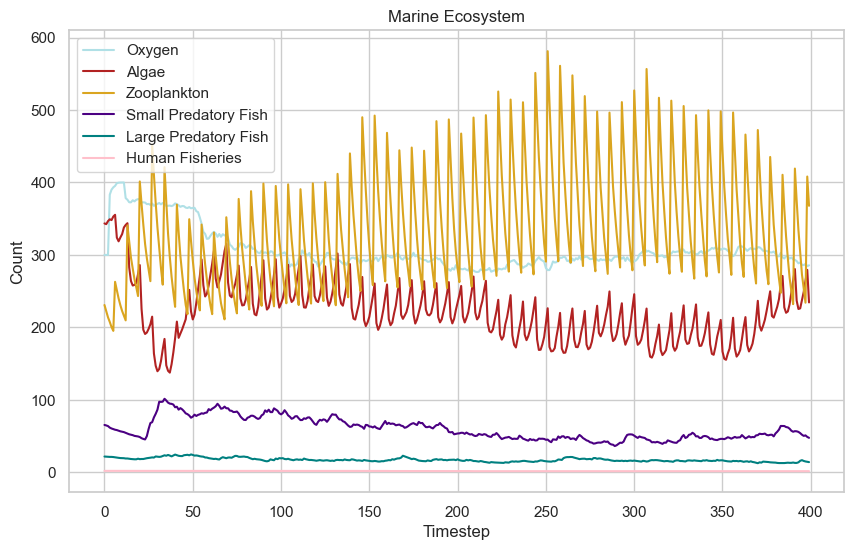

In [ ]:
# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(data=average_data['OX'], label='Oxygen', color='powderblue')
sns.lineplot(data=average_data['AL'], label='Algae', color='firebrick')
sns.lineplot(data=average_data['Zooplankton'], label='Zooplankton', color='goldenrod')
sns.lineplot(data=average_data['Small Predatory Fish'], label='Small Predatory Fish', color='indigo')
sns.lineplot(data=average_data['Large Predatory Fish'], label='Large Predatory Fish', color='teal')
sns.lineplot(data=average_data['HF'], label='Human Fisheries', color = 'pink')

plt.xlabel('Timestep')
plt.ylabel('Count')
plt.title('Marine Ecosystem')
plt.legend()
plt.grid(True)
plt.show()